# Intermediate Frequency Heating

In [1]:
import os
import sys
import subprocess
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import distributed

import synthesizAR
from synthesizAR.interfaces.ebtel import EbtelInterface
from synthesizAR.interfaces.ebtel import read_xml,write_xml
from synthesizAR.atomic import EmissionModel
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

sys.path.append('../../scripts/')
from constrained_heating_model import CustomHeatingModel

%matplotlib inline

In [ ]:
ar = synthesizAR.Field.restore(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/base_field/')

## Hydrodynamics

Run EBTEL and load electron temperatures and densities

In [ ]:
heating_options = {
    'duration': 200.0,
    'duration_rise': 100.0,
    'duration_decay': 100.0,
    'stress_level': 1.,
    'power_law_slope': -2.5,
    'frequency_parameter': 1.,
}

In [ ]:
heating_model = CustomHeatingModel(heating_options)

In [ ]:
base_config = read_xml('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [ ]:
ebtel_interface = EbtelInterface(
    base_config,heating_model,
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/hydro_config/',
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/hydro_results/')

In [ ]:
heating_model.constrain_distribution(ar,
                                     tolerance=1e-3,
                                     ar_flux_constraint=1e7,
                                     sigma_increase=1.,sigma_decrease=1e-6,
                                     verbose=True)

In [ ]:
ar.configure_loop_simulations(ebtel_interface)

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
for l in ar.loops:
    ebtel_runner(l)

In [ ]:
ar.load_loop_simulations(
    ebtel_interface,
    savefile='/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/loop_parameters.h5')

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in ar.loops[::5]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.05)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(0,base_config['total_time'])
axes[0].set_ylim(0,25)
axes[1].set_ylim(0,50)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

In [ ]:
ar.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/field_checkpoint')

## Atomic Physics

Load the emission model and compute the NEI populations

In [ ]:
ar = synthesizAR.Field.restore(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/field_checkpoint/')

In [4]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33082 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


In [ ]:
em_model = EmissionModel.restore(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/base_emission_model.json')

In [ ]:
future = em_model.calculate_ionization_fraction(
    ar,
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/ionization_fractions.h5',
    interface=EbtelInterface,)

In [ ]:
em_model.save(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/emission_model.json')

## Forward Modeling

Flatten the counts and bin them

In [2]:
ar = synthesizAR.Field.restore(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/field_checkpoint/')

In [3]:
em_model = EmissionModel.restore(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/emission_model.json'
)

In [5]:
aia = InstrumentSDOAIA([0, 30000]*u.s,ar.magnetogram.observer_coordinate)
observer = synthesizAR.Observer(ar, [aia], parallel=True)

In [6]:
observer.build_detector_files(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/',
    0.5 * u.Mm
)

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [7]:
futures = observer.flatten_detector_counts(
    emission_model=em_model,
    interpolate_hydro_quantities=False,
)

In [8]:
bin_futures = observer.bin_detector_counts(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/')

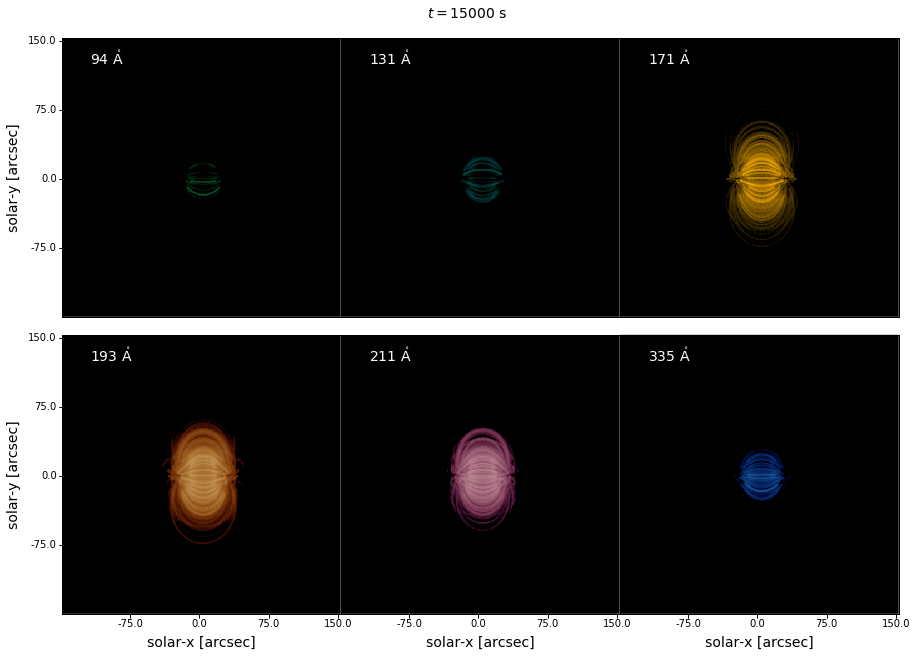

In [9]:
plot_aia_channels(
    aia,15e3*u.s,
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/intermediate_frequency/')